## Neural Networks in PyMC3 estimated with Variational Inference
(c) 2016 by Thomas Wiecki

## Current trends in Machine Learning

There are currently three big trends in machine learning: **Probabilistic Programming**, **Deep Learning** and "**Big Data**". Inside of PP, a lot of innovation is in making things scale using **Variational Inference**. In this blog post, I will show how to use **Variational Inference** in [PyMC3](http://pymc-devs.github.io/pymc3/) to fit a simple Bayesian Neural Network. I will also discuss how bridging Probabilistic Programming and Deep Learning can open up very interesting avenues to explore in future research.

### Probabilistic Programming at scale
**Probabilistic Programming** allows very flexible creation of custom probabilistic models and is mainly concerned with **insight** and learning from your data. The approach is inherently **Bayesian** so we can specify **priors** to inform and constrain our models and get uncertainty estimation in form of a **posterior** distribution. Using [MCMC sampling algorithms](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) we can draw samples from this posterior to very flexibly estimate these models. [PyMC3](http://pymc-devs.github.io/pymc3/) and [Stan](http://mc-stan.org/) are the current state-of-the-art tools to consruct and estimate these models. One major drawback of sampling, however, is that it's often very slow, especially for high-dimensional models. That's why more recently, **variational inference** algorithms have been developed that are almost as flexible as MCMC but much faster. Instead of drawing samples from the posterior, these algorithms instead fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem. [ADVI](http://arxiv.org/abs/1506.03431) -- Automatic Differentation Variational Inference -- is implemented in [PyMC3](http://pymc-devs.github.io/pymc3/) and [Stan](http://mc-stan.org/), as well as a new package called [Edward](https://github.com/blei-lab/edward/) which is mainly concerned with Variational Inference. 

Unfortunately, when it comes traditional ML problems like classification or (non-linear) regression, Probabilistic Programming often plays second fiddle (in terms of accuracy and scalability) to more algorithmic approaches like [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) (e.g. [random forests](https://en.wikipedia.org/wiki/Random_forest) or [gradient boosted regression trees](https://en.wikipedia.org/wiki/Boosting_(machine_learning)).

### Deep Learning

Now in its third renaissance, deep learning has been making headlines repeatadly by dominating almost any object recognition benchmark, [kicking ass at Atari games](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), and [beating the world-champion Lee Sedol at Go](http://www.nature.com/nature/journal/v529/n7587/full/nature16961.html). From a statistical point, Neural Networks are extremely good non-linear function approximators and representation learners. While mostly known for classification, they have been extended to unsupervised learning with [AutoEncoders](https://arxiv.org/abs/1312.6114) and in all sorts of other interesting ways (e.g. [Recurrent Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), or [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html) to estimate multimodal distributions). Why do they work so well? No one really knows as the statistical properties are still not fully understood.

A large part of the innoviation in deep learning is the ability to train these extremely complex models. This rests on several pillars:
* Speed: facilitating the GPU allowed for much faster processing.
* Software: frameworks like [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/) allow flexible creation of abstract models that can then be optimized and compiled to CPU or GPU.
* Learning algorithms: training on sub-sets of the data -- stochastic gradient descent -- allows us to train these models on massive amounts of data. Techniques like drop-out avoid overfitting.
* Architectural: A lot of innovation comes from changing the input layers, like for convolutional neural nets, or the output layers, like for [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html).

### Bridging Deep Learning and Probabilistic Programming
On one hand we Probabilistic Programming which allows us to build rather small and focused models in a very principled and well-understood way to gain insight into our data; on the other hand we have deep learning which uses many heuristics to train huge and highly complex models that are amazing at prediction. Recent innovations in variational inference allow probabilistic programming to scale model complexity as well as data size. We are thus at the cusp of being able to combine these two approaches to hopefully unlock new innovations in Machine Learning. For more motivation, see also [Dustin Tran's](https://twitter.com/dustinvtran) recent [blog post](http://dustintran.com/blog/a-quick-update-edward-and-some-motivations/).

While this would allow Probabilistic Programming to be applied to a much wider set of interesting problems, I believe this bridging also holds great promise for innovations in Deep Learning. Some ideas are:
* **Uncertainty in predictions**: As we will see below, the Bayesian Neural Network informs us about the uncertainty in its predictions. I think uncertainty is an underappreciated concept in Machine Learning as it's clearly important for real-world applications. But it could also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.
* **Uncertainty in representations**: We also get uncertainty estimates of our weights which could inform us about the stability of the learned representations of the network.
* **Regularization with priors**: Weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).
* **Transfer learning with informed priors**: If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like [GoogLeNet](https://arxiv.org/abs/1409.4842). 
* **Hierarchical Neural Networks**: A very powerful approach in Probabilistic Programming is hierarchical modeling that allows pooling of things that were learned on sub-groups to the overall population (see my tutorial on [Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)). Applied to Neural Networks, in hierarchical data sets, we could train individual neural nets to specialize on sub-groups while still being informed about representations of the overall population. For example, imagine a network trained to classify car models from pictures of cars. We could train a hierarchical neural network where a sub-neural network is trained to tell apart models from only a single manufacturer. The intuition being that all cars from a certain manufactures share certain similarities so it would make sense to train individual networks that specialize on brands. However, due to the individual networks being connected at a higher layer, they would still share information with the other specialized sub-networks about features that are useful to all brands. Interestingly, different layers of the network could be informed by various levels of the hierarchy -- e.g. early layers that extract visual lines could be identical in all sub-networks while the higher-order representations would be different. The hierarchical model would learn all that from the data.
* **Other hybrid architectures**: We can more freely build all kinds of neural networks. For example, Bayesian non-parametrics could be used to flexibly adjust the size and shape of the hidden layers to optimally scale the network architecture to the problem at hand during training. Currently, this requires costly hyper-parameter optimization and a lot of tribal knowledge.

## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

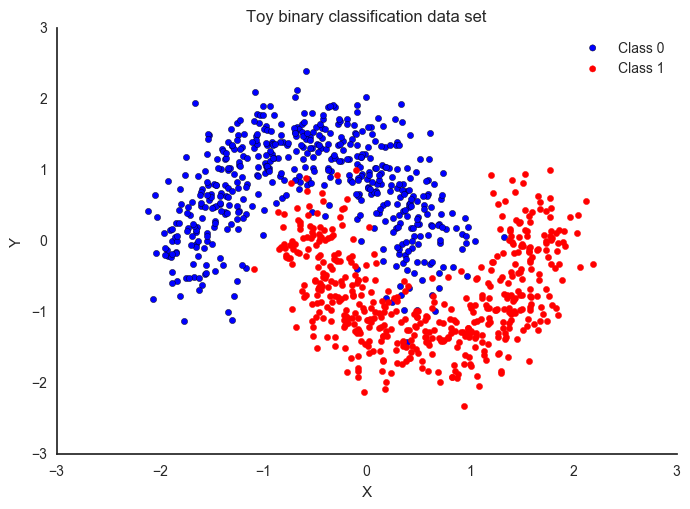

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [4]:
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like [`NUTS`](http://pymc-devs.github.io/pymc3/api.html#nuts) which works pretty well in this case but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the brand-new [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) variational inference algorithm which was recently added to `PyMC3`. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [5]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Average ELBO = -167.9: 100%|██████████| 50000/50000 [00:17<00:00, 2860.61it/s]
Finished [100%]: Average ELBO = -138.57


CPU times: user 20 s, sys: 844 ms, total: 20.9 s
Wall time: 1min 16s


< 40 seconds on my older laptop. That's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational posterior using `sample_vp()` (this is just sampling from Normal distributions, so not at all the same like MCMC):

In [6]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:00<00:00, 12175.62it/s]


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

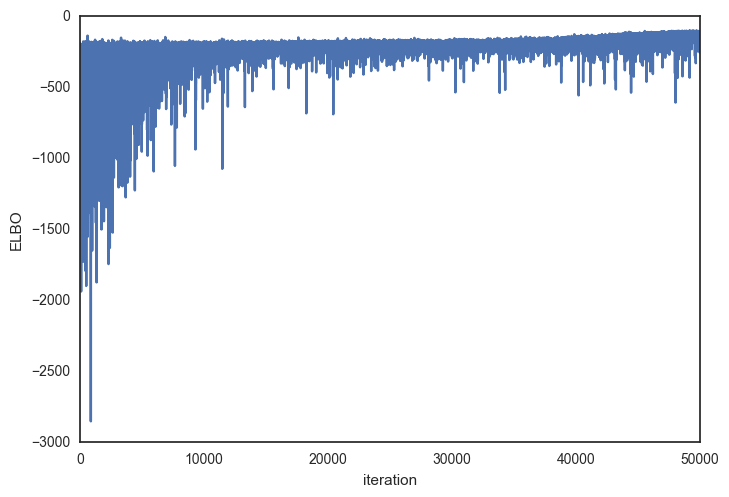

In [7]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We use [`sample_ppc()`](http://pymc-devs.github.io/pymc3/api.html#pymc3.sampling.sample_ppc) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [8]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:04<00:00, 116.76it/s]


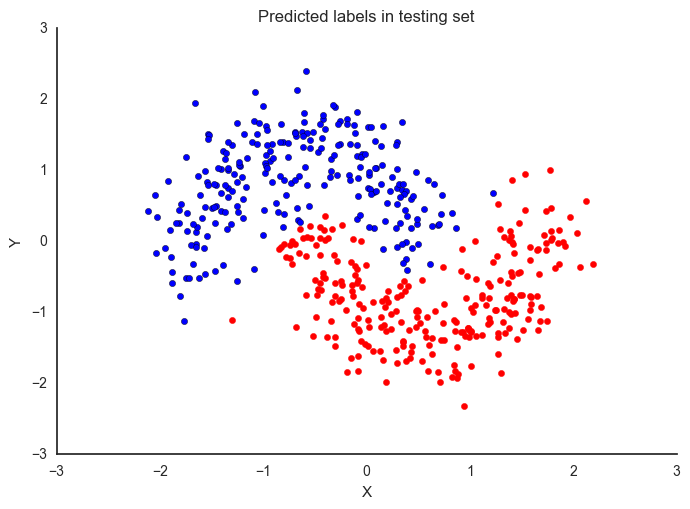

In [22]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');
plt.savefig("nn-0.png",dpi=400)

In [10]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.6%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [11]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X, Y = grid
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [12]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

100%|██████████| 500/500 [00:04<00:00, 113.79it/s]


### Probability surface

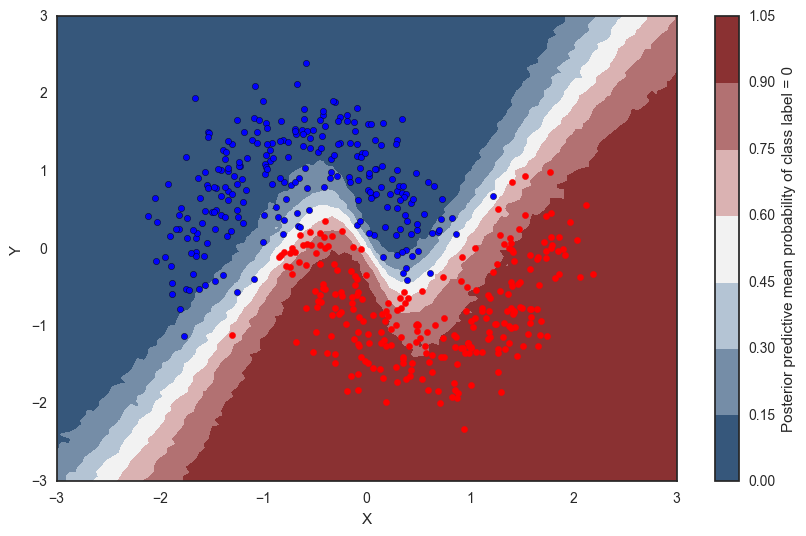

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
plt.savefig("nn-1.png",dpi=400)

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

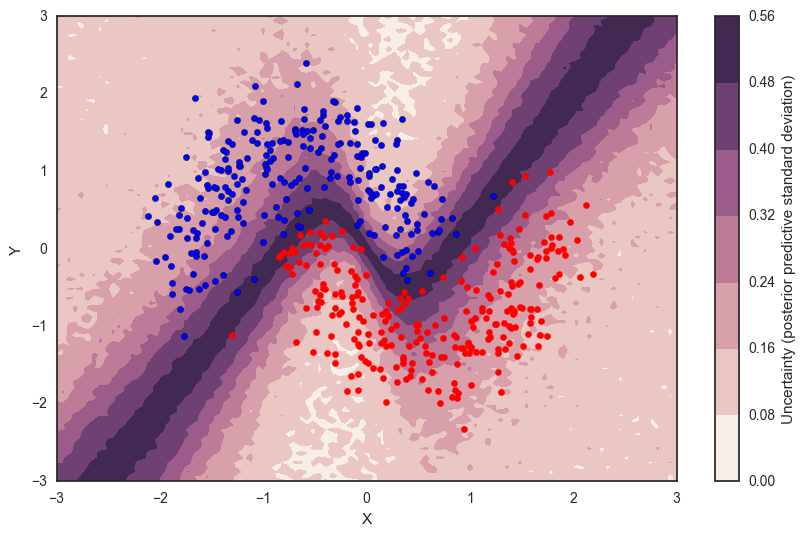

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');
plt.savefig("nn-2.png",dpi=400)

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI: Scaling data size

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [15]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train), 
    create_minibatch(Y_train),
)

total_size = len(Y_train)

While the above might look a bit daunting, I really like the design. Especially the fact that you define a generator allows for great flexibility. In principle, we could just pool from a database there and not have to keep all the data in RAM. 

Lets pass those to `advi_minibatch()`:

In [16]:
%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Average ELBO = -111.71: 100%|██████████| 50000/50000 [00:14<00:00, 3441.73it/s]
Finished minibatch ADVI: ELBO = -137.60


CPU times: user 19 s, sys: 512 ms, total: 19.5 s
Wall time: 46.3 s


In [17]:
with neural_network:    
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:00<00:00, 15032.53it/s]


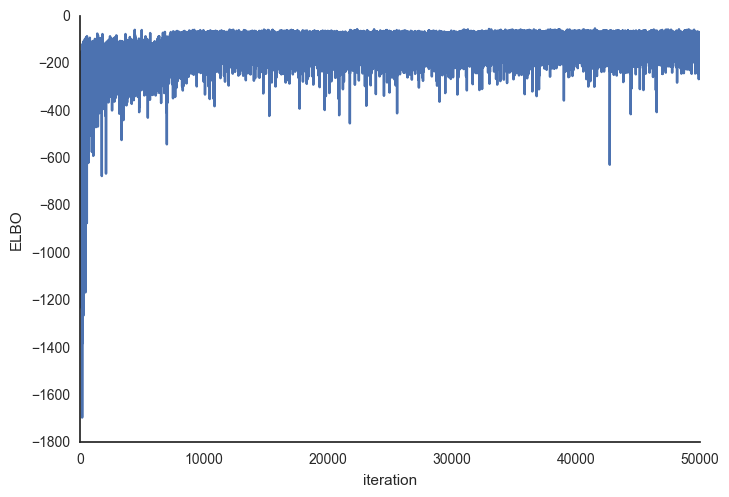

In [18]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

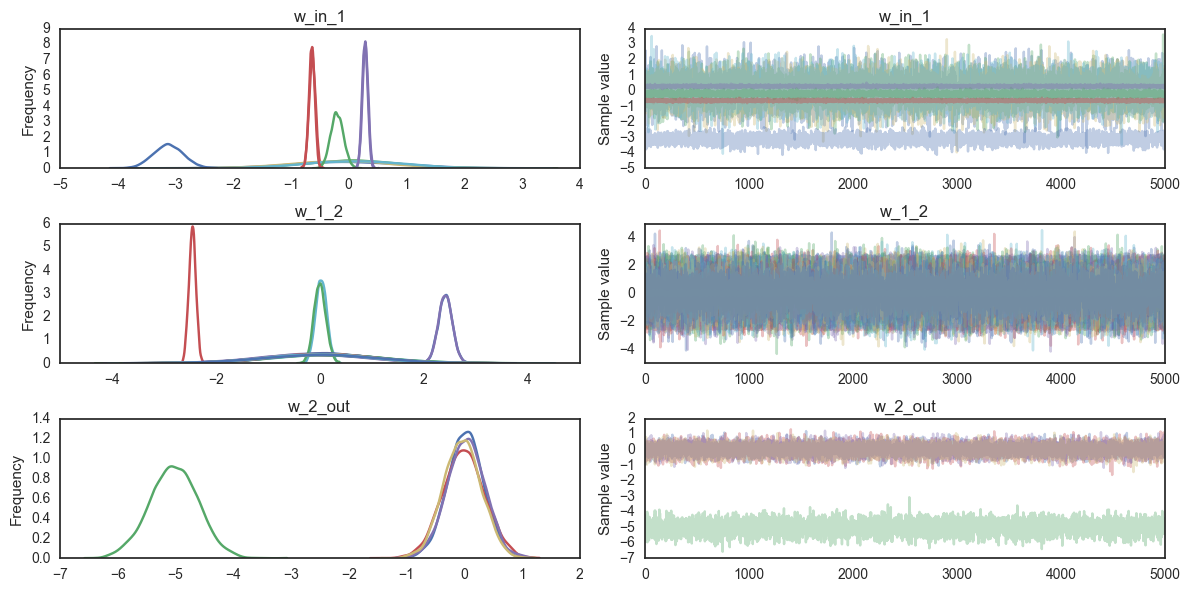

In [19]:
pm.traceplot(trace);

## Summary

Hopefully this blog post demonstrated a very powerful new inference algorithm available in [PyMC3](http://pymc-devs.github.io/pymc3/): [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi). I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.

## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. Ideally, we wouldn't have to build the models by hand as I did above, but use the convenient syntax of `Lasagne` to construct the architecture, define our priors, and run ADVI. 

While we haven't successfully run `PyMC3` on the GPU yet, it should be fairly straight forward (this is what `Theano` does after all) and further reduce the running time significantly. If you know some `Theano`, this would be a great area for contributions!

You might also argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets.

I also presented some of this work at PyData London, view the video below:
<iframe width="560" height="315" src="https://www.youtube.com/embed/LlzVlqVzeD8" frameborder="0" allowfullscreen></iframe>

Finally, you can download this NB [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network.ipynb). Leave a comment below, and [follow me on twitter](https://twitter.com/twiecki).

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on ADVI in PyMC3, including the mini-batch implementation as well as the sampling from the variational posterior. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.